# Task 6 - Advanced Optimization


In this assignment you will practice using Dropout layer as well various Parameter Update Schemes. The goals of this assignment are as follows:
* understand the basic Image Classification pipeline and the data-driven approach (train/predict stages)
* implement Dropout Layer
* implement popular Parameter Update Schemes:

      * Vanilla Stochastic Gradient Descent
      * SGD with Momentum Update
      * Nesterov Accelerated Gradient Update (NAG)
      * Adaptive Sub-Gradient Update (AdaGrad)
      * Root Mean Square Propagation Update (RMSProp)
      * Adaptive Moment Estimation Update (Adam)


---
---
#[Part 0] Import Libraries and Load Data

---
## 1 - Import Libraries
Import required libraries

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
import sklearn
from sklearn.metrics import accuracy_score

%matplotlib inline
%load_ext autoreload
%autoreload 2

Write down your Name and Student ID

In [2]:
## --- start your code here ----

NIM = print('21/480350/PA/20863')
Nama = print("Andi Muhammad Yanwar")

## --- end your code here ----

21/480350/PA/20863
Andi Muhammad Yanwar


---
## 2 - Layer API

This part is exacly the same as Task 3
for that, we've already provide you the implementation of the basic layers

---
### a. Affine Functions

In [3]:
def affine_forward(x, W, b ):

    N = x.shape[0]
    a1 = x.reshape(N, -1)
    v = np.dot(a1, W) + b
    cache = (x, W, b)

    return v, cache

# --------------------------------

def affine_backward(dout, cache):

    x, W, b = cache
    N = x.shape[0]
    dW = np.dot(x.reshape(N, -1).T,dout)
    db = np.sum(dout, axis=0, keepdims=True)
    dx = dout.dot(W.T).reshape(x.shape)

    return dx, dW, db


---
### b. ReLU Functions

In [4]:
def relu_forward(x):
    out = x * (x > 0).astype(float)
    cache = x
    return out, cache

# --------------------------------

def relu_backward(dout, cache):
    dx = dout * (cache >= 0)

    return dx

---
### c. Softmax Functions

In [5]:
def softmax(x):
    x -= np.max(x)
    x_exp = np.exp(x)
    x_sum = np.sum(x_exp, axis = 1, keepdims = True)
    score = x_exp / x_sum

    return score

# --------------------------------

def softmax_loss(score, y):

    num_examples = score.shape[0]
    number_list = range(num_examples)
    corect_logprobs = -np.log(score[number_list,y])
    loss = np.sum(corect_logprobs)/num_examples

    dscores = score
    dscores[range(num_examples),y] -= 1
    dscores /= num_examples


    return loss, dscores

---
### d. Affine-Relu Block

In [6]:
def affine_relu_forward(X, W, b):

    act, fc_cache = affine_forward(X, W, b)
    out, relu_cache = relu_forward(act)

    cache = (fc_cache, relu_cache)
    return out, cache

# --------------------------------

def affine_relu_backward(dout, cache):

    fc_cache, relu_cache = cache
    dact = relu_backward(dout, relu_cache)
    dX, dW, db = affine_backward(dact, fc_cache)

    return dX, dW, db


---
## 3 - Load CIFAR-10

In [7]:
(X_train_ori, y_train), (X_test_ori, y_test) = tf.keras.datasets.cifar10.load_data()
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

170498071/170498071 [==============================] - 4s 0us/step


---
## 4 - Split Validation Data

In [8]:
X_val_ori = X_train_ori[-1000:,:]
y_val     = y_train[-1000:]

X_train_ori = X_train_ori[:-1000, :]
y_train     = y_train[:-1000]

---
## 5 - Normalize and Reshape Data

In [9]:
X_train = X_train_ori.astype('float32')
X_val   = X_val_ori.astype('float32')
X_test  = X_test_ori.astype('float32')

mean_image = np.mean(X_train, axis = 0)
X_train -= mean_image
X_val   -= mean_image
X_test  -= mean_image

X_train = X_train.reshape((X_train.shape[0],X_train.shape[1]*X_train.shape[2]*X_train.shape[3]))
X_val = X_val.reshape((X_val.shape[0],X_val.shape[1]*X_val.shape[2]*X_val.shape[3]))
X_test = X_test.reshape((X_test.shape[0],X_test.shape[1]*X_test.shape[2]*X_test.shape[3]))

print('X_train.shape =',X_train.shape)
print('X_val.shape   =',X_val.shape)
print('X_test.shape  =',X_test.shape)

y_train = y_train.ravel()
y_val   = y_val.ravel()
y_test  = y_test.ravel()

print('\ny_train.shape =',y_train.shape)
print('y_val.shape   =',y_val.shape)
print('y_test.shape  =',y_test.shape)

X_train.shape = (49000, 3072)
X_val.shape   = (1000, 3072)
X_test.shape  = (10000, 3072)

y_train.shape = (49000,)
y_val.shape   = (1000,)
y_test.shape  = (10000,)


---
---
# [Part 1] Dropout Layer

Dropout [1] is a technique for regularizing neural networks by **randomly** setting some features to **zero** during the forward pass of training.

<center>
<img src="https://miro.medium.com/proxy/1*iWQzxhVlvadk6VAJjsgXgg.png" width=500>
 </center>

In this exercise you will implement a dropout layer and modify your fully-connected network to optionally use dropout.

[1] [Geoffrey E. Hinton et al, "Improving neural networks by preventing co-adaptation of feature detectors", arXiv 2012](https://arxiv.org/abs/1207.0580)

---
## 0 - Mask Review
To implement Dropout, we'll make a mask matrix to filter any number (activation) below the probability value. You've implement something similar to this before in MaxPool backward, but let's review that

---
#### <font color='red'>**EXERCISE:** </font>

**Implement Filter example for dropout**

Create a mask to filter any number below 5 from the given matrix


In [10]:
np.random.seed(231)
x = np.random.randint(0,10,(5, 5))

#Create a mask to filter any number below 5 from the given matrix
mask = x < 5


Check your implementations

In [11]:
print('x')
print(x)
print('\nmask')
print(mask)

x
[[7 0 4 9 6]
 [2 7 4 1 2]
 [2 2 1 3 1]
 [1 1 9 5 2]
 [3 6 3 0 2]]

mask
[[False  True  True False False]
 [ True False  True  True  True]
 [ True  True  True  True  True]
 [ True  True False False  True]
 [ True False  True  True  True]]


**Expected Output**:
<pre>
x
[[7 0 4 9 6]
 [2 7 4 1 2]
 [2 2 1 3 1]
 [1 1 9 5 2]
 [3 6 3 0 2]]

mask
[[False  True  True False False]
 [ True False  True  True  True]
 [ True  True  True  True  True]
 [ True  True False False  True]
 [ True False  True  True  True]]



---
## 1 - Forward Dropout

First we implement the Forward Function.

* In here, you should implement the <font color='red'>**INVERTED DROPOUT**</font>, not the vanilla version of dropout.

* Keep in mind that **prob** is the probability to <font color='blue'>**KEEP A NEURON OUTPUT**</font><br>This might be contrary to some sources, where it is referred to
    as the probability of dropping a neuron output.

* Since dropout behaves differently during training and testing, make sure to implement the operation for both modes.

---
#### <font color='red'>**EXERCISE:** </font>

**Implement the forward pass for dropout**



In [12]:
def dropout_forward(x, dropout_param):
    """
    Performs the forward pass for (INVERTED) dropout.

    Inputs:
    - x             : Input data, of any shape
    - dropout_param : A dictionary with the following keys:
      - prob  : Dropout parameter. We keep each neuron output with probability p.
      - mode  : 'test' or 'train'. If the mode is train, then perform dropout;
                if the mode is test, then just return the input.
      - seed  : Seed for the random number generator. Passing seed makes this
                function deterministic, which is needed for gradient checking
                but not in real networks.

    Outputs:
    - out     : Array of the same shape as x.
    - cache   : tuple (dropout_param, mask). In training mode,
                mask is the dropout mask that was used to multiply the input;
                in test mode, mask is None.

    """
    prob, mode = dropout_param['prob'], dropout_param['mode']
    if 'seed' in dropout_param:
        np.random.seed(dropout_param['seed'])

    mask = None
    out = None

    if mode == 'train':

        # create mask to drop, call np.random.rand in the same size of x
        rand = np.random.rand(*x.shape)

        # then filter those with value below prob
        mask = (rand < prob)

        # drop neuron by multiplying x with mask
        x = x * mask

        # return the drop result by first dividing x with prob (inverted schemes)
        out = x / prob



    elif mode == 'test':

        # for test time, just return x as it is
        out = x

    # store the mask and parameter for backward pass
    cache = (dropout_param, mask)
    out = out.astype(x.dtype, copy=False)

    return out, cache



Check your implementations

In [13]:
np.random.seed(231)
x = np.random.randn(500, 500) + 10

for pr in [0.25, 0.4, 0.7]:
    out, _ = dropout_forward(x, {'prob': pr, 'mode': 'train', 'seed': 123})
    out_test, _ = dropout_forward(x, {'prob': pr, 'mode': 'train', 'seed': 123})

    print('Running tests with dropout probability of ', pr)
    print('Mean of input x                           :', x.mean())
    print('Mean of train-time output                 :', out.mean())
    print('Mean of test-time  output                 :', out_test.mean())
    print('Fraction of train-time output set to zero :', (out == 0).mean())
    print('Fraction of test-time  output set to zero :', (out_test == 0).mean())
    print('\n')

Running tests with dropout probability of  0.25
Mean of input x                           : 10.000207878477502
Mean of train-time output                 : 10.010204726265409
Mean of test-time  output                 : 10.010204726265409
Fraction of train-time output set to zero : 0.749812
Fraction of test-time  output set to zero : 0.749812


Running tests with dropout probability of  0.4
Mean of input x                           : 10.000207878477502
Mean of train-time output                 : 9.981730013577316
Mean of test-time  output                 : 9.981730013577316
Fraction of train-time output set to zero : 0.600676
Fraction of test-time  output set to zero : 0.600676


Running tests with dropout probability of  0.7
Mean of input x                           : 10.000207878477502
Mean of train-time output                 : 9.9817111089715
Mean of test-time  output                 : 9.9817111089715
Fraction of train-time output set to zero : 0.30126
Fraction of test-time  output s

**Expected Output**:
<pre>
Running tests with dropout probability of  0.25
Mean of input x                           : 2.5035147792443206
Mean of train-time output                 : 10.014059116977283
Mean of test-time  output                 : 2.5035147792443206
Fraction of train-time output set to zero : 0.749784
Fraction of test-time  output set to zero : 0.749784


Running tests with dropout probability of  0.4
Mean of input x                           : 1.0003021979972544
Mean of train-time output                 : 2.5007554949931357
Mean of test-time  output                 : 1.0003021979972544
Fraction of train-time output set to zero : 0.900004
Fraction of test-time  output set to zero : 0.900004


Running tests with dropout probability of  0.7
Mean of input x                           : 0.7022154229440579
Mean of train-time output                 : 1.0031648899200825
Mean of test-time  output                 : 0.7022154229440579
Fraction of train-time output set to zero : 0.929764
Fraction of test-time  output set to zero : 0.929764


---
## 2 - Backward Dropout

Perform the backward pass for the <font color='red'>**INVERTED DROPOUT**</font>.

---
#### <font color='red'>**EXERCISE:** </font>

**Implement the backward pass for dropout**



In [14]:
def dropout_backward(dout, cache):
    """
    Perform the backward pass for (inverted) dropout.

    Inputs:
    - dout: Upstream derivatives, of any shape
    - cache: (dropout_param, mask) from dropout_forward.
    """

    # retrieve the parameter and mask filter
    dropout_param, mask = cache
    mode = dropout_param['mode']


    if mode == 'train':

        # propagate the gradient only to neuron that is not dropped
        # drop the gradient by multiplying dout with mask
        dx = dout * mask

        # retrieve the probability parameter
        prob = dropout_param['prob']

        # scale the gradient by dividing gradient dx with the probability
        dx = dx / prob

    elif mode == 'test':

        # for test time, just return dout as it is
        dx = dout



    return dx


Check your implementations

In [15]:
np.set_printoptions(precision=3)
np.random.seed(231)
x = np.random.randn(5, 5) + 3
dout = np.random.randn(*x.shape)

dropout_param = {'mode': 'train', 'prob': 0.2, 'seed': 123}
out, cache = dropout_forward(x, dropout_param)
print('forward output:\n')
print(out,'\n')

dx = dropout_backward(dout, cache)
print('dout:\n')
print(dout,'\n')
print('dx:\n')
print(dx)

forward output:

[[ 0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.    19.761  0.   ]
 [ 0.    14.26  19.448  0.     0.   ]
 [ 0.     0.     0.     0.     0.   ]] 

dout:

[[-0.797  0.12  -0.657  0.269  0.334]
 [ 0.274  0.762 -0.696  0.292 -0.385]
 [ 0.123 -1.429  0.703 -0.859 -1.14 ]
 [-1.585 -0.015 -0.322  0.568 -0.2  ]
 [ 1.273  1.273  1.581 -1.756  0.922]] 

dx:

[[-0.     0.    -0.     0.     0.   ]
 [ 0.     0.    -0.     0.    -0.   ]
 [ 0.    -0.     0.    -4.293 -0.   ]
 [-0.    -0.077 -1.608  0.    -0.   ]
 [ 0.     0.     0.    -0.     0.   ]]


**Expected Output**:
<pre>
forward output:
[[ 0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.    19.761  0.   ]
 [ 0.    14.26  19.448  0.     0.   ]
 [ 0.     0.     0.     0.     0.   ]]

dout:

[[-0.797  0.12  -0.657  0.269  0.334]
 [ 0.274  0.762 -0.696  0.292 -0.385]
 [ 0.123 -1.429  0.703 -0.859 -1.14 ]
 [-1.585 -0.015 -0.322  0.568 -0.2  ]
 [ 1.273  1.273  1.581 -1.756  0.922]]

dx:

[[-0.     0.    -0.     0.     0.   ]
 [ 0.     0.    -0.     0.    -0.   ]
 [ 0.    -0.     0.    -4.293 -0.   ]
 [-0.    -0.077 -1.608  0.    -0.   ]
 [ 0.     0.     0.    -0.     0.   ]]


---
---
# [Part 2] Optimizers API

Gradient descent is one of the most popular algorithms to perform optimization and by far the most common way to optimize neural networks.

At the same time, every state-of-the-art Deep Learning library contains implementations of various algorithms to optimize gradient descent.

<br>


<center>
<img src='http://ruder.io/content/images/2016/09/saddle_point_evaluation_optimizers.gif' height=300><br><img src='https://image.ibb.co/gHFUTz/opt2.gif' height=250>
<img src='https://miro.medium.com/max/1240/1*Y2KPVGrVX9MQkeI8Yjy59Q.gif' height=250>
  
  
</center>

<br>


For the next vanilla SGD, we give you the implementation as you've implement it many times before.

But now we write it as a function, so <font color='red'>**Observe carefully**</font> how the implementation is done.

Then complete the next exercises with similar implementation

---
## 1 - Stochastic Gradient Descent

The most basic optimization in Neural Network
<center>
<img src='https://image.ibb.co/em1Q1K/sgd.png' width=700>
</center>

<br>


<table>
  <tr>
    <td>
      <font size=2>
        perform gradient update
      </font></td>
    <td>:</td>
    <td><font size=3>
      $$
      \begin{align}
      W_{t+1}=W_t - \alpha\nabla f(W_t)
      \end{align}
      $$</font>
    </td>
  </tr>
</table>

<br>

<table>
  <tr>
    <td><font size=3>
      $$
      \begin{align}
      \alpha\\W_t
      \end{align}
      $$ </font>
    </td>
    <td><font size=2>
      <pre>(lr) learning rate<br><br>(w)  old weight</pre>  </font>    
    </td>    
    <td>|<br>|<br>|<br>|</td>
    <td><font size=3>
      $$
      \begin{align}
      W_{t+1}\\\nabla f(W_t)
      \end{align}
      $$ </font>
    </td>
    <td><font size=2>
      <pre>(new_w) new weight<br><br>(grad)  weight gradient </pre>  </font>    
    </td>
  </tr>
</table>




In [16]:
def sgd(w, grad, optim_param):
    """
    Performs vanilla stochastic gradient descent.

    optim_param format:
    - learning_rate: Scalar learning rate.
    """

    # set default value in parameter if it has not yet initialized
    optim_param.setdefault('lr', 1e-2)

    # retrieve parameter
    lr = optim_param['lr']

    # perform parameter update
    new_w = w - lr * grad

    return new_w

Check your implementations

In [17]:
np.set_printoptions(precision=5)
np.random.seed(231)
w = np.random.randn(2, 2)+1
dout = np.random.randn(*w.shape)
param = {}

print('dout:')
print(dout,'\n')

print('w:')
print(w,'\n')

w = sgd(w, dout, param)
print('w iteration 1:')
print(w,'\n')

w = sgd(w, dout, param)
print('w iteration 2:')
print(w)


dout:
[[-0.07473 -0.77502]
 [-0.1498   1.86173]] 

w:
[[ 1.41794  2.3971 ]
 [-0.7859   0.29117]] 

w iteration 1:
[[ 1.41869  2.40485]
 [-0.78441  0.27255]] 

w iteration 2:
[[ 1.41944  2.4126 ]
 [-0.78291  0.25394]]


---
## 2 - SGD With Momentum

A method that helps accelerate SGD in the relevant direction and dampens oscillation in Vanilla SGD

<center>
<img src='https://machinelearningnotepad.files.wordpress.com/2018/04/momentum-011.png?w=1140' height=180></img></center>

<br>

The formula for SGD With Momentum is as follow:

<br>


<table>
  <tr>
    <td>
      <font size=2>
        calculate the new velocity<br><br><br><br>
        perform momentum update
      </font></td>
    <td>:<br><br><br><br>:</td>
    <td><font size=3>
      $$
      \begin{align}
      v_t &= \mu\ v_{t-1}-\alpha\nabla f(W_t)\\\\
      W_{t+1}&=W_t + v_t\\
      \end{align}
      $$</font>
    </td>
  </tr>
</table>

<br>

<table>
  <tr>
    <td><font size=3>
      $$
      \begin{align}
      v_t\\\mu\\\alpha
      \end{align}
      $$ </font>
    </td>
    <td><font size=2>
      <pre>(v)   velocity<br><br>(mu)  momentum<br><br>(lr)  learning rate </pre>  </font>    
    </td>
    <td>|<br>|<br>|<br>|<br>|<br>|</td>
    <td><font size=3>
      $$
      \begin{align}
      W_t\\W_{t+1}\\\nabla f(W_t)
      \end{align}
      $$ </font>
    </td>
    <td><font size=2>
      <pre>(w)     old weight<br><br>(new_w) new weight<br><br>(grad)  weight gradient </pre>  </font>    
    </td>
  </tr>
</table>




---
#### <font color='red'>**EXERCISE:** </font>

**Implement SGD Update with Momentum**



In [18]:
def momentum(w, grad, optim_param):
    """
    Performs Stochastic Gradient Descent update with momentum.

    optim_param format:
    - lr      : Scalar learning rate.
    - momentum: Scalar between 0 and 1 giving the momentum value.
                Setting momentum = 0 reduces to sgd.
    - velocity: A numpy array of the same shape as w and dw used to store a
                moving average of the gradients.
    """

    # set default value in parameter if it has not yet initialized
    optim_param.setdefault('lr', 1e-2)
    optim_param.setdefault('momentum', 0.9)
    optim_param.setdefault('velocity', np.zeros_like(w))

    # retrieve parameters
    lr = optim_param['lr']
    mu = optim_param['momentum']
    v = optim_param['velocity']


    # calculate the new velocity
    v = mu * v - lr * grad

    # perform momentum update
    new_w = w + v

    # save the velocity for further update
    optim_param['velocity'] = v

    return new_w

Check your implementations

In [19]:
np.random.seed(231)
w = np.random.randn(2, 2)+1
dout = np.random.randn(*w.shape)
param = {}

print('dout:')
print(dout,'\n')

print('w:')
print(w,'\n')

w = momentum(w, dout, param)
print('w iteration 1:')
print(w,'\n')

w = momentum(w, dout, param)
print('w iteration 2:')
print(w)



dout:
[[-0.07473 -0.77502]
 [-0.1498   1.86173]] 

w:
[[ 1.41794  2.3971 ]
 [-0.7859   0.29117]] 

w iteration 1:
[[ 1.41869  2.40485]
 [-0.78441  0.27255]] 

w iteration 2:
[[ 1.42011  2.41958]
 [-0.78156  0.23718]]


**Expected Output**:
<pre>
dout:
[[-0.07473 -0.77502]
 [-0.1498   1.86173]]

w:
[[ 1.41794  2.3971 ]
 [-0.7859   0.29117]]

w iteration 1:
[[ 1.41869  2.40485]
 [-0.78441  0.27255]]

w iteration 2:
[[ 1.42011  2.41958]
 [-0.78156  0.23718]]


---
## 3 - Nesterov Accelerated Gradient

A method that helps direct and accelerate the gradient in Momentum Update



<center>
<img src='https://golden-storage-production.s3.amazonaws.com/topic_images/7a00dcd221e745708101d89f4c4c2a5c.png'  height=200></img></center>


<br>

[Nesterov, Y. (1983). A method for unconstrained convex minimization problem with the rate of convergence o(1/k2)](http://mpawankumar.info/teaching/cdt-big-data/nesterov83.pdf)


---

<br>

The basic formula for Nesterov Update is as follow:


<br>

<table>
  <tr>
    <td>
      <font size=2>
        calculate the new velocity<br>based on lookahead<br><br><br>
        perform nesterov update
      </font></td>
    <td>:<br><br><br><br>:</td>
    <td>
      <font size=3>
        $$
        \begin{align}
        v_t &= \mu\ v_{t-1}-\alpha\nabla f(W_t+\mu\ v_{t-1})\\\\
        W_{t+1}&=W_t + v_t\\
        \end{align}
        $$
      </font>
    </td>
  </tr>
</table>

<br>

But we'll use the <font color='blue'>**Inverted Formula**</font>:

<br>


<table>
  <tr>
    <td>
      <font size=2>
        store the old velocity<br><br>
        calculate the new velocity<br><br>
        perform nesterov update
      </font></td>
    <td>:<br><br>:<br><br>:</td>
    <td>
      <font size=3>
        $$
        \begin{align}
        v_{prev} &= v_t\\
        v_t &= \mu\ v_{t-1}-\alpha\nabla f(W_t)\\
        W_{t+1}&=W_t + (-\mu)\ v_{prev} + (1+\mu)v_t\\
        \end{align}
        $$
      </font>
    </td>
  </tr>
</table>

<br>


<table>
  <tr>
    <td><font size=3>
      $$
      \begin{align}
      v_t\\\mu\\\alpha
      \end{align}
      $$ </font>
    </td>
    <td><font size=2>
      <pre>(v)   velocity<br><br>(mu)  momentum<br><br>(lr)  learning rate </pre>  </font>    
    </td>
    <td>|<br>|<br>|<br>|<br>|<br>|</td>
    <td><font size=3>
      $$
      \begin{align}
      W_t\\W_{t+1}\\\nabla f(W_t)
      \end{align}
      $$ </font>
    </td>
    <td><font size=2>
      <pre>(w)     old weight<br><br>(new_w) new weight<br><br>(grad)  weight gradient </pre>  </font>    
    </td>
  </tr>
</table>

---
#### <font color='red'>**EXERCISE:** </font>

**Implement Nesterov Accelerated Gradient Update**



In [20]:
def nag(w, grad, optim_param):
    """
    Performs Nesterov Accelerated Gradient Descent update.

    optim_param format:
    - lr      : Scalar learning rate.
    - momentum: Scalar between 0 and 1 giving the momentum value.
                Setting momentum = 0 reduces to sgd.
    - velocity: A numpy array of the same shape as w and dw used to store a
                moving average of the gradients.
    """
    # set default value in parameter if it has not yet initialized
    optim_param.setdefault('lr', 1e-2)
    optim_param.setdefault('momentum', 0.9)
    optim_param.setdefault('velocity', np.zeros_like(w))

    # retrieve parameters
    lr = optim_param['lr']
    mu = optim_param['momentum']
    v = optim_param['velocity']


    # store the previous velocity
    v_prev = v.copy()

    # calculate the new velocity
    v = mu * v - lr * grad

    # perform nesterov update
    new_w = w + mu * v - lr * grad

    # save the velocity for further update
    optim_param['velocity'] = v

    return new_w


Check your implementations

In [21]:
np.random.seed(231)
w = np.random.randn(2, 2)+1
dout = np.random.randn(*w.shape)
param = {}

print('dout:')
print(dout,'\n')

print('w:')
print(w,'\n')

w = nag(w, dout, param)
print('w iteration 1:')
print(w,'\n')

w = nag(w, dout, param)
print('w iteration 2:')
print(w)



dout:
[[-0.07473 -0.77502]
 [-0.1498   1.86173]] 

w:
[[ 1.41794  2.3971 ]
 [-0.7859   0.29117]] 

w iteration 1:
[[ 1.41936  2.41183]
 [-0.78306  0.2558 ]] 

w iteration 2:
[[ 1.42139  2.43283]
 [-0.779    0.20535]]


**Expected Output**:
<pre>
dout:
[[-0.07473 -0.77502]
 [-0.1498   1.86173]]

w:
[[ 1.41794  2.3971 ]
 [-0.7859   0.29117]]

w iteration 1:
[[ 1.41936  2.41183]
 [-0.78306  0.2558 ]]

w iteration 2:
[[ 1.42139  2.43283]
 [-0.779    0.20535]]


---
## 4 - Adaptive Sub-Gradient


Adagrad is an algorithm for gradient-based optimization that **adapts** the learning rate to the parameters.

It performs
* **smaller updates** (i.e. low learning rates) for parameters associated with **frequently occurring features**, and
* **larger updates** (i.e. high learning rates) for parameters associated with **infrequent features**.

For this reason, it is well-suited for dealing with sparse data

 Adagrad greatly improved the robustness of SGD and used it for training large-scale neural nets


<br>

[Duchi, J., Hazan, E., & Singer, Y. (2011). Adaptive Subgradient Methods for Online Learning and Stochastic Optimization](http://jmlr.org/papers/v12/duchi11a.html)






---
The basic formula for ADAGRAD Update is as follow:


<br>

<table>
  <tr>
    <td>
      <font size=2>
        calculate<br>new gradient build-up<br><br><br>
        perform adagrad update
      </font></td>
    <td>:<br><br><br><br>:</td>
    <td>
      <font size=3>
        $$
        \begin{align}
        g_t &= g_{t-1} + \nabla f(W_t)^2\\\\
        W_{t+1}&=W_t -\frac{\alpha}{\sqrt{g_t}+\epsilon}\nabla f(W_t)\\
        \end{align}
        $$</font>
    </td>
  </tr>
</table>

<br>


<table>
  <tr>
    <td><font size=3>
      $$
      \begin{align}
      g_t\\\alpha\\\epsilon
      \end{align}
      $$ </font>
    </td>
    <td><font size=2>
      <pre>(gt)  gradient build-up<br><br>(lr)  learning rate<br><br>(e)   epsilon </pre>  </font>    
    </td>
    <td>|<br>|<br>|<br>|<br>|<br>|</td>
    <td><font size=3>
      $$
      \begin{align}
      W_t\\W_{t+1}\\\nabla f(W_t)
      \end{align}
      $$ </font>
    </td>
    <td><font size=2>
      <pre>(w)     old weight<br><br>(new_w) new weight<br><br>(grad)  weight gradient </pre>  </font>    
    </td>
  </tr>
</table>

---
#### <font color='red'>**EXERCISE:** </font>

**Implement ADAGRAD Update**



In [22]:
def adagrad(w, grad, optim_param):
    """
    Performs Adaptive Sub-Gradient update.

    optim_param format:
    - lr: Scalar learning rate.
    - gt: A numpy array of the same shape as w and dw used to store a
          cache of the gradients build-up.
    - e : epsilon to prevent division by zero.
    """

    # set default value in parameter if it has not yet initialized
    optim_param.setdefault('lr', 1e-2)
    optim_param.setdefault('cache', np.zeros_like(w))
    optim_param.setdefault('epsilon', 1e-8)

    # retrieve parameters
    lr = optim_param['lr']
    gt = optim_param['cache']
    e = optim_param['epsilon']

    # calculate new gradient build-up
    gt = gt + grad ** 2

    # perform adagrad update
    new_w = w - lr * grad / (np.sqrt(gt) + e)

    # save the gradient build-up for further update
    optim_param['cache'] = gt

    return new_w

Check your implementations

In [23]:
np.random.seed(231)
w = np.random.randn(2, 2)+1
dout = np.random.randn(*w.shape)
param = {}

print('dout:')
print(dout,'\n')

print('w:')
print(w,'\n')

w = adagrad(w, dout, param)
print('w iteration 1:')
print(w,'\n')

w = adagrad(w, dout, param)
print('w iteration 2:')
print(w)



dout:
[[-0.07473 -0.77502]
 [-0.1498   1.86173]] 

w:
[[ 1.41794  2.3971 ]
 [-0.7859   0.29117]] 

w iteration 1:
[[ 1.42794  2.4071 ]
 [-0.7759   0.28117]] 

w iteration 2:
[[ 1.43501  2.41417]
 [-0.76883  0.2741 ]]


**Expected Output**:
<pre>
dout:
[[-0.07473 -0.77502]
 [-0.1498   1.86173]]

w:
[[ 1.41794  2.3971 ]
 [-0.7859   0.29117]]

w iteration 1:
[[ 1.42794  2.4071 ]
 [-0.7759   0.28117]]

w iteration 2:
[[ 1.43501  2.41417]
 [-0.76883  0.2741 ]]


---
## 5 - Root Mean Square Propagation

RMSprop is an unpublished, adaptive learning rate method proposed by Geoff Hinton in [Lecture 6e of his Coursera Class](http://www.cs.toronto.edu/~tijmen/csc321/slides/lecture_slides_lec6.pdf).

It’s famous for not being published, yet being very well-known; most deep learning framework include the implementation of it out of the box.

RMSprop and Adadelta have both been developed independently around the same time stemming from the need to resolve Adagrad's radically diminishing learning rates


---
The basic formula for RMSProp Update is as follow:


<br>

<table>
  <tr>
    <td>
      <font size=2>
        calculate new decayed<br> gradient build-up<br><br><br>
        perform rmsprop update
      </font></td>
    <td>:<br><br><br><br>:</td>
    <td>
      <font size=3>
        $$
        \begin{align}
        \\g_t &= \gamma\ g_{t-1} + (1-\gamma)\ \nabla f(W_t)^2\\\\
        W_{t+1}&=W_t -\frac{\alpha}{\sqrt{g_t}+\epsilon}\nabla f(W_t)\\
        \end{align}
        $$</font>
    </td>
  </tr>
</table>

<br>


<table>
  <tr>
    <td><font size=3>
      $$
      \begin{align}
      g_t\\\gamma\\\alpha\\\epsilon
      \end{align}
      $$ </font>
    </td>
    <td><font size=2>
      <pre>(gt)  gradient build-up<br><br>(dr)  decay rate<br><br>(lr)  learning rate<br><br>(e)   epsilon </pre>  </font>    
    </td>
    <td>|<br>|<br>|<br>|<br>|<br>|</td>
    <td><font size=3>
      $$
      \begin{align}
      W_t\\W_{t+1}\\\nabla f(W_t)
      \end{align}
      $$ </font>
    </td>
    <td><font size=2>
      <pre>(w)     old weight<br><br>(new_w) new weight<br><br>(grad)  weight gradient </pre>  </font>    
    </td>
  </tr>
</table>

---
#### <font color='red'>**EXERCISE:** </font>

**Implement RMSProp Update**



In [24]:
def rmsprop(w, grad, optim_param):
    """
    Uses the RMSProp update rule, which uses a moving average of squared
    gradient values to set adaptive per-parameter learning rates.

    optim_param format:
    - lr        : Scalar learning rate.
    - decay_rate: Scalar between 0 and 1 giving the decay rate for the squared
                  gradient cache.
    - epsilon   : Small scalar used for smoothing to avoid dividing by zero.
    - cache     : Moving average of second moments of gradients.
    """

    # set default value in parameter if it has not yet initialized
    optim_param.setdefault('lr', 1e-2)
    optim_param.setdefault('decay_rate', 0.99)
    optim_param.setdefault('epsilon', 1e-8)
    optim_param.setdefault('cache', np.zeros_like(w))


    # retrieve parameters
    lr = optim_param['lr']
    dr = optim_param['decay_rate']
    gt = optim_param['cache']
    e  = optim_param['epsilon']

    # calculate new gradient build-up
    gt = dr * gt + (1 - dr) * grad ** 2

    # perform rmsprop update
    new_w = w - lr * grad / (np.sqrt(gt) + e)

    # save the gradient build-up for further update
    optim_param['cache'] = gt

    return new_w



Check your implementations

In [25]:
np.random.seed(231)
w = np.random.randn(2, 2)+1
dout = np.random.randn(*w.shape)
param = {}

print('dout:')
print(dout,'\n')

print('w:')
print(w,'\n')

w = rmsprop(w, dout, param)
print('w iteration 1:')
print(w,'\n')

w = rmsprop(w, dout, param)
print('w iteration 2:')
print(w)



dout:
[[-0.07473 -0.77502]
 [-0.1498   1.86173]] 

w:
[[ 1.41794  2.3971 ]
 [-0.7859   0.29117]] 

w iteration 1:
[[ 1.51794  2.4971 ]
 [-0.6859   0.19117]] 

w iteration 2:
[[ 1.58883  2.56799]
 [-0.61502  0.12028]]


**Expected Output**:
<pre>
dout:
[[-0.07473 -0.77502]
 [-0.1498   1.86173]]

w:
[[ 1.41794  2.3971 ]
 [-0.7859   0.29117]]

w iteration 1:
[[ 1.51794  2.4971 ]
 [-0.6859   0.19117]]

w iteration 2:
[[ 1.58883  2.56799]
 [-0.61502  0.12028]]


---
## 6 - Adaptive Moment Estimation Optimizer

ADAM is another method that computes adaptive learning rates for each parameter.

In addition to storing an exponentially decaying average of past squared gradients vt like Adadelta and RMSprop, Adam also keeps an exponentially decaying average of past gradients mt, similar to momentum.

Whereas momentum can be seen as a ball running down a slope, Adam behaves like a heavy ball with friction, which thus prefers flat minima in the error surface.


[Kingma, D. P., & Ba, J. L. (2015). Adam: a Method for Stochastic Optimization](https://arxiv.org/abs/1412.6980)


---
The basic formula for ADAM Update is as follow:


<br>

<table>
  <tr>
    <td>
      <font size=2>
        first moment (mean)<br> build-up<br><br><br>
        second moment (variance)<br>build-up<br><br><br><br>
        bias correction<br><br><br><br><br>
        perform adam update<br><br>
      </font></td>
    <td>:<br><br><br><br><br>:<br><br><br><br><br>:<br><br><br><br><br>:<br><br></td>
    <td>
      <font size=3>
        $$
        \begin{align}
        m_t &= \beta_1\ m_{t-1} + (1-\beta_1)\ \nabla f(W_t)\\\\
        v_t &= \beta_2\ v_{t-1} + (1-\beta_2)\ \nabla f(W_t)^2\\\\
        \hat{m_t}&=\frac{m_t}{1-(\beta_1)^t} \ \ ;\ \
        \hat{v_t} =\frac{v_t}{1-(\beta_2)^t}\\\\
        W_{t+1}&=W_t -\frac{\alpha}{\sqrt{\hat{v_t}}+\epsilon}\hat{m_t}
        \end{align}
$$</font>
    </td>
  </tr>
</table>

<br>


<table>
  <tr>
    <td><font size=3>
      $$
      \begin{align}
      \beta_1\\\beta_2\\m_t\\v_t\\\hat{m_t}\\\hat{v_t}
      \end{align}
      $$ </font>
    </td>
    <td><font size=2>
      <pre>(beta1) beta mean<br><br>(beta2) beta variance<br><br>(m)     1st moment (mean) buildup<br><br>(v)     2nd moment (variance) buildup<br><br>(mb)    1st moment (mean) bias<br><br>(mv)    2nd moment (variance) bias</pre>  </font>    
    </td>
    <td>|<br>|<br>|<br>|<br>|<br>|<br>|<br>|<br>|<br>|<br>|<br>|</td>
    <td><font size=3>
      $$
      \begin{align}
      \alpha\\\epsilon\\W_t\\W_{t+1}\\\nabla f(W_t)
      \end{align}
      $$ </font>
    </td>
    <td><font size=2>
      <pre>(lr)    learning rate<br><br>(e)     epsilon <br><br>(w)     old weight<br><br>(new_w) new weight<br><br>(grad)  weight gradient </pre>  </font>    
    </td>
  </tr>
</table>

---
#### <font color='red'>**EXERCISE:** </font>

**Implement ADAM Update**



In [26]:
def adam(w, grad, optim_param):
    """
    Uses the Adam update rule, which incorporates moving averages of both the
    gradient and its square and a bias correction term.

    config format:
    - lr      : Scalar learning rate.
    - beta1   : Decay rate for moving average of first moment of gradient.
    - beta2   : Decay rate for moving average of second moment of gradient.
    - epsilon : Small scalar used for smoothing to avoid dividing by zero.
    - m       : Moving average of first moment of gradient.
    - v       : Moving average of second moment of gradient (squared gradient).
    - t       : Iteration number.
    """

    # set default value in parameter if it has not yet initialized
    optim_param.setdefault('lr', 1e-2)
    optim_param.setdefault('beta1', 0.9)
    optim_param.setdefault('beta2', 0.999)
    optim_param.setdefault('epsilon', 1e-8)
    optim_param.setdefault('m', np.zeros_like(w))
    optim_param.setdefault('v', np.zeros_like(w))
    optim_param.setdefault('t', 0)

    # retrieve parameters
    lr = optim_param['lr']
    beta1 = optim_param['beta1']
    beta2 = optim_param['beta2']
    e = optim_param['epsilon']
    m = optim_param['m']
    v = optim_param['v']
    optim_param['t'] += 1


    # get the iteration number
    t = optim_param['t']

    # calculate first moment (mean) build-up
    m = beta1 * m + (1 - beta1) * grad

    # calculate second moment (variance) build-up
    v = beta2 * v + (1 - beta2) * (grad ** 2)

    # perform bias correction
    mb = m / (1 - beta1 ** t)
    vb = v / (1 - beta2 ** t)

    # perform adam update
    new_w = w - lr * mb / (np.sqrt(vb) + e)

    # save the mean and variance for further update
    optim_param['m'] = m
    optim_param['v'] = v


    return new_w

Check your implementations

In [27]:
np.random.seed(231)
w = np.random.randn(2, 2)+1
dout = np.random.randn(*w.shape)
param = {}

print('dout:')
print(dout,'\n')

print('w:')
print(w,'\n')

w = adam(w, dout, param)
print('w iteration 1:')
print(w,'\n')

w = adam(w, dout, param)
print('w iteration 2:')
print(w)



dout:
[[-0.07473 -0.77502]
 [-0.1498   1.86173]] 

w:
[[ 1.41794  2.3971 ]
 [-0.7859   0.29117]] 

w iteration 1:
[[ 1.42794  2.4071 ]
 [-0.7759   0.28117]] 

w iteration 2:
[[ 1.43794  2.4171 ]
 [-0.7659   0.27117]]


**Expected Output**:
<pre>
dout:
[[-0.07473 -0.77502]
 [-0.1498   1.86173]]

w:
[[ 1.41794  2.3971 ]
 [-0.7859   0.29117]]

w iteration 1:
[[ 1.42794  2.4071 ]
 [-0.7759   0.28117]]

w iteration 2:
[[ 1.43794  2.4171 ]
 [-0.7659   0.27117]]


---
---
# [Part 3] Deep Neural Network API

For this exercise, we provide you these codes to easily define architecture then train and test deep neural network

You've seen implementation similar to this in the optional parts in the previous exercise

---
## 1 - Weight Initializer

Weight initialization function

In [28]:
def init_weights_affine(d_in, d_out, std=1e-2):
    """
    Weight initialization for affine layer

    Inputs:
    - d_in  : int, number of input dimension
    - d_out : int, number of output dimension
    - std   : standard deviation for generating weights
    - seed  : random seed

    Outputs:
    - W: list of Weights
    - b: list of biases
    """

    W = std * np.random.randn(d_in, d_out).astype(np.float32)
    b = np.zeros((1, d_out)).astype(np.float32)

    return W, b


---
## 2 - Model Initializer

Model Initialization Function to initialize weights for each defined layer in architecture

This function will receive a list of designed neural net **architecture**, and it will initialize weights according to the layer type and parameters given in the designed architecture.

The architecture feed in is a list of layers that is stacked in a **Sequential Model** fashion. The Layer is also a list of named layer type followed by its required parameters.

The Model initializer receive **3 kinds** of layer:

<br>
<font size=10>
<table border=1 solid>
  <tr border=1>
    <th><font size=2>      Layer Name    </font></th>
    <th><font size=2>      Definition and Parameters    </font></th>
    <th colspan=2><font size=2>      Parameters    </font></th>
  </tr>
  <tr>
    <td><font size=3>      <pre>'input'</pre>    </font></td>
    <td><font size=2>      input layer, <br>to determine the input shape    </font></td>
    <td><font size=3>      <pre>(h, w, c)</pre>    </font></td>
    <td><font size=2>      tuple of input dimension     </font></td>
  </tr>
  <tr>
    <td><font size=3>      <pre>'affine'</pre>    </font></td>
    <td><font size=2>      affine layer, <br>followed by relu activation    </font></td>
    <td><font size=3>      <pre>d_out</pre>    </font></td>
    <td><font size=2>      integer, <br>number of output neurons     </font></td>
  </tr>
  <tr>
    <td><font size=3>      <pre>'dropout'</pre>    </font></td>
    <td><font size=2>      dropout layer    </font></td>
    <td><font size=3>      <pre>prob</pre>    </font></td>
    <td><font size=2>      float, <br>dropout probability     </font></td>
  </tr>
</table>

</font>

In [29]:
def init_model(architecture, std=1e-2):

    """
    Inputs:
    - architecture  : list of layer name and paramters


    Outputs:
    - neural net model, a tuple of:
      - architecture: list of layer name and paramters
      - params      : list of compact layer weights and parameters

    """

    # define output container
    params = {}
    d_in = 0

    # the first layer must be input layer
    assert(architecture[0][0]=='input')

    # loop read list of layer
    for i in range(len(architecture)):

        # read the layer information
        layer = architecture[i]

        # if the layer is input, get the input shape
        if layer[0]=='input':
            d_in = layer[1]

        # if the layer is affine layer,
        # initialize weight and bias
        elif layer[0]=='affine':

            # get the previous output shape
            d_out = layer[1]

            # initialize weight and bias
            params['W'+str(i)], params['b'+str(i)] = init_weights_affine(d_in, d_out, std)

            # set this layer output shape as previous output shape
            # for the next layer
            d_in = d_out

        # if the layer is affine dropout,
        elif layer[0]=='dropout':

            # get the dropout probability
            prob = layer[1]

            # compact the parameters
            params[i] = {'prob': prob, 'mode':'train'}

    # combine the weights and its parameters into a tuple of model
    model = (architecture, params)

    # return the network model
    return model

---
## 3 - Predict Function

In [30]:
def predict(model, X):
    """
    Inputs:
    - model : Network model architecture and weights
    - X     : Input data, of shape(N, D)

    Output:
    - y_pred : list of class prediction
    """

    # get the model architecture and weights
    architecture, params = model

    # get number of layers
    n_layer = len(architecture)

    # set input X as the first activation
    act = X

    # loop i over n_layer-1
    for i in range(n_layer-1):

      # get layer architecture
      layer = architecture[i]

      # check layer type
      if layer[0]=='affine':
          # call affine relu forward function with input act, W[i], and b[i]
          act, _ = affine_relu_forward(act, params['W'+str(i)],  params['b'+str(i)])

      elif layer[0]=='dropout':
          # change mode to testing
          params[i]['mode'] = 'test'

          # call dropout forward function with input act and its param argument
          act, _ = dropout_forward(act, params[i])

          # change back mode to training
          params[i]['mode'] = 'train'

    # calculate last layer score by calling affine forward function using act, W[i+1], and b[i+1]
    last_layer, _ = affine_forward(act, params['W'+str(i+1)],  params['b'+str(i+1)])

    # take the maximum prediction from the last layer and use that column to get the class
    y_pred = last_layer.argmax(axis=-1)

    return y_pred


---
## 4 - Training Function

In [31]:
def train(model, X, y, X_val, y_val,
                optimizer, optim_param,
                lr_decay=0.9, reg=0.25, epochs=20,
                batch_size=200,
                verbose=True, print_every=100):
    """
    Inputs:
    - model      : Network model architecture and weights
    - X          : Array, shape (N, C, H, W) of training images
    - y          : Array, shape (N,) of labels for training images
    - X_val      : Array, shape (N_val, C, H, W) of validation images
    - y_val      : Array, shape (N_val,) of labels for validation images
    - optimizer  : optimizer function
    - optim_param: optimizer parameters
    - lr_decay   : float, 0-1, decay rate to reduce learning rate each epoch
    - reg        : float, regularization rate
    - epochs     : int, number of training epoch
    - batch_size : int, number of batch used each step
    - verbose    : boolean, verbosity

    Outputs:
    - model      : Network model architecture and weights
    - history    : list of training history [loss, train_acc, val_acc]

    """



    # extract input size
    num_train, dim = X.shape

    # assume y takes values 0...K-1 where K is number of classes
    num_classes = np.max(y) + 1

    # check if data train is divisible by batch size
    assert num_train % batch_size==0, "data train "+str(num_train)+" is not divisible by batch size"+str(batch_size)

    # total iteration per epoch
    num_iter = num_train // batch_size

    #start iteration counts
    it = 0

    # get the model architecture
    architecture, params = model

    # get the layer number (including output layer)
    n_layer = len(architecture)

    # Run gradient to optimize W
    loss_history = []
    train_acc_history = [0]
    val_acc_history = [0]

    # dictionary for gradients
    grads = {}
    optim_params = {}

    # extract the optimizer parameters
    for i in range(1,n_layer):
        optim_params['W'+str(i)] = dict(optim_param)
        optim_params['b'+str(i)] = dict(optim_param)




    print('start training')

    for ep in range(epochs):

        # Shuffle data train index
        train_rows = np.arange(num_train)
        np.random.shuffle(train_rows)

        # split index into mini batches
        id_batch = np.split(train_rows, num_iter)

        for batch in id_batch:

            X_batch = X[batch]
            y_batch = y[batch]

            # store all cache in dictionary
            cache = {}

            # first layer activation input is X_batch
            act = X_batch


            # ------------------------------------------------
            # 1. Forward Pass
            # ------------------------------------------------

            # loop i over n_layer-1
            for i in range(n_layer-1):

                # get layer architecture
                layer = architecture[i]

                # call the appropriate layer
                if layer[0]=='affine':
                    # call affine relu forward function with input act, W[i], and b[i]
                    act, cache[i] = affine_relu_forward(act, params['W'+str(i)],  params['b'+str(i)])

                elif layer[0]=='dropout':
                    # call dropout forward function with input act and its param argument
                    act, cache[i] = dropout_forward(act, params[i])

            # calculate last layer score by calling affine forward function using act, W[-1], and b[-1]
            last_layer, cache[i+1] = affine_forward(act, params['W'+str(i+1)],  params['b'+str(i+1)])

            # calculate softmax score by calling softmax function using last_layer score
            softmax_score = softmax(last_layer)



            # ------------------------------------------------
            # 2. Calculate Loss
            # ------------------------------------------------

            # evaluate loss and gradient by calling softmax_loss function using softmax_score and y_batch
            loss, dout = softmax_loss(softmax_score, y_batch)

            # add regularization to the loss:
            #    for each weights, calculate the sum square, multiply regularization strength
            #    then add it to the loss
            for i in range(1,n_layer):
                w = params.get('W'+str(i),0)
                loss += reg * np.sum(w * w)

            # append the loss history
            loss_history.append(loss)


            # ------------------------------------------------
            # 3. Backward Pass
            # ------------------------------------------------

            # calculate last weights gradient by calling affine backward function using dout and cache[n_layer-1]
            dact, grads['W'+str(n_layer-1)],  grads['b'+str(n_layer-1)] = affine_backward(dout, cache[n_layer-1])


            #loop i from n_layer-2 down to 0
            for i in range(n_layer-2,-1,-1):

                # get layer architecture
                layer = architecture[i]

                # check layer type
                if layer[0]=='affine':
                    # call affine relu backward function with input dact and cache[i]
                    dact, grads['W'+str(i)],  grads['b'+str(i)] = affine_relu_backward(dact, cache[i])

                    # add regularization to gradient
                    grads['W'+str(i)] += 2 * reg * params['W'+str(i)]

                elif layer[0]=='dropout':
                    # call dropout backward function with input dact and cache[i]
                    dact = dropout_backward(dact, cache[i])


            # perform parameter update according to the optimizer function
            # pass the weights, gradients, and its optimization parameters to optimizer function
            for i in range(1,n_layer):
                if 'W'+str(i) in params:
                    params['W'+str(i)] = optimizer(params['W'+str(i)], grads['W'+str(i)], optim_params['W'+str(i)])
                    params['b'+str(i)] = optimizer(params['b'+str(i)], grads['b'+str(i)], optim_params['b'+str(i)])


            # iteration count
            it +=1

            if verbose and it % print_every == 1:
                print ('iteration',it,'/',(num_iter*epochs),'\t(epoch', ep+1,'/',epochs, '): \tloss =', loss)


        # record model at this epoch
        model_epoch = (architecture, params)

        # At the end of one epoch
        # 1. Check accuracy
        #    calculate the training accuracy by calling predict function on model_epoch and X_batch
        #    and compare it to y_batch. Then calculate the mean correct (accuracy in range 0-1)
        train_acc = (predict(model, X_batch) == y_batch).mean()
        train_acc_history.append(train_acc)

        # 2. Calculate the training accuracy by calling predict function on model_epoch and X_val
        #    and compare it to y_val. Then calculate the mean correct (accuracy in range 0-1)
        val_acc = (predict(model, X_val) == y_val).mean()
        val_acc_history.append(val_acc)

        # 3. Decay learning rate
        #    multiply learning rate with decay
        #    see sigmoid train function
        optim_param['lr'] *= lr_decay


    # store trained weights in model
    model = (architecture, params)

    # store all trining history
    history = [loss_history, train_acc_history, val_acc_history]

    # return model and training history
    return model, history

---
---
# [Part 4] Comparing Dropout Layer

For the next step, we'll train a** 4 Layered Neural Network** to classify CIFAR-10

We'll compare the result between models trained **with** and **without** Dropout Layer


---
## 1 - Model w/o Dropout

First, let's train a 4 layered Neural Net Without Dropout with only **50 neurons** in each hidden layer,

just to check our Deep Neural Network API (Sanity Check)

The result should match exactly like your previous **Task 3** exercises

---
### a. Define Model

In [32]:
# architecture options:
# input, input_size
# affine, hidden_size
# dropout, dropout_prob

architecture =[
    ['input', 32*32*3],
    ['affine', 50],
    ['affine', 50],
    ['affine', 50],
    ['affine', 10]
]


Now print the architecture list

In [33]:
for i in range(len(architecture)):
    layer = architecture[i]
    print('layer',i,':',layer)

layer 0 : ['input', 3072]
layer 1 : ['affine', 50]
layer 2 : ['affine', 50]
layer 3 : ['affine', 50]
layer 4 : ['affine', 10]


next, initialize the model

In [34]:
model = init_model(architecture)
model[1].keys()

dict_keys(['W1', 'b1', 'W2', 'b2', 'W3', 'b3', 'W4', 'b4'])

---
### b. Train Model

#### <font color='red'>**EXERCISE:** </font>

Use the Training Function and train a **four layer neural network** without **dropout** using **Vanilla SGD**


In [35]:
optim_param = {'lr':1e-2}
model, history = train(model, X_train, y_train,
                                 X_val, y_val,
                                 sgd, optim_param,
                                 lr_decay=0.95, reg=0.01,
                                 batch_size=200, epochs=20)


start training
iteration 1 / 4900 	(epoch 1 / 20 ): 	loss = 2.461572105256064
iteration 101 / 4900 	(epoch 1 / 20 ): 	loss = 2.4545701146092553
iteration 201 / 4900 	(epoch 1 / 20 ): 	loss = 2.442007001413915
iteration 301 / 4900 	(epoch 2 / 20 ): 	loss = 2.22728300892089
iteration 401 / 4900 	(epoch 2 / 20 ): 	loss = 2.182357971613447
iteration 501 / 4900 	(epoch 3 / 20 ): 	loss = 2.043803159623571
iteration 601 / 4900 	(epoch 3 / 20 ): 	loss = 1.9649721744018702
iteration 701 / 4900 	(epoch 3 / 20 ): 	loss = 1.9936473629039149
iteration 801 / 4900 	(epoch 4 / 20 ): 	loss = 1.7506365909509347
iteration 901 / 4900 	(epoch 4 / 20 ): 	loss = 1.9395201481880477
iteration 1001 / 4900 	(epoch 5 / 20 ): 	loss = 1.7093854896928549
iteration 1101 / 4900 	(epoch 5 / 20 ): 	loss = 1.766918476113073
iteration 1201 / 4900 	(epoch 5 / 20 ): 	loss = 1.691745996052521
iteration 1301 / 4900 	(epoch 6 / 20 ): 	loss = 1.7060275168392687
iteration 1401 / 4900 	(epoch 6 / 20 ): 	loss = 1.585795118564746
i

**EXPECTED OUTPUT**:
<pre>
loss should starts around 2.45 and ends around 1.39

---
### c. Visualize Training
Visualize the loss, and train-validation accuracy

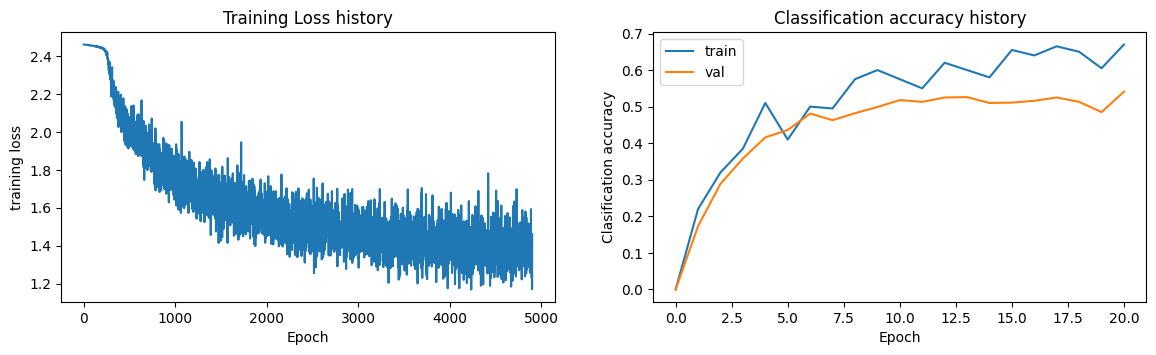

In [36]:
loss, train_acc, val_acc = history

plt.rcParams['figure.figsize'] = [14, 3.5]
plt.subplots_adjust(wspace=0.2)

plt.subplot(121)
plt.plot(loss)
plt.xlabel('Epoch')
plt.ylabel('training loss')
plt.title('Training Loss history')

plt.subplot(122)
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.title('Classification accuracy history')
plt.show()

**EXPECTED RESULTS**:

You should get almost the **exact same result** as your previous **Task 3** implementation

In [37]:
y_pred = predict(model, X_train)
accuracy = sklearn.metrics.accuracy_score(y_train, y_pred)
print('Training Accuracy   = %.1f%%' % (accuracy*100))

y_pred = predict(model, X_val)
accuracy = sklearn.metrics.accuracy_score(y_val, y_pred)
print('Validation Accuracy = %.1f%%' % (accuracy*100))


Training Accuracy   = 58.5%
Validation Accuracy = 54.1%


**EXPECTED OUTPUT**:

<pre>You should be able to get about <b>~57%</b> accuracy on training set and about <b>~52%</b> accuracy on validation set
using the initial run</pre>



---
## 2 - Model with Dropout

Next, let's train a set of 4 layered Neural Nets but now using **Dropout** after each hidden layer

We'll try **4** different Dropout probabilites from **1 to 0.25** in 0.25 increments

<br>

Note that with Dropout **probability=1** means we use all neurons (**no dropout**)

---
### a. Define Model

For greater effect on the dropout, we'll use **500 neurons** in each hidden layer

In [38]:
# architecture options:
# input, input_size
# affine, hidden_size
# dropout, dropout_prob

def model_dropout(prob):

    architecture =[
        ['input', 32*32*3],
        ['affine', 500],
        ['dropout', prob],
        ['affine', 500],
        ['dropout', prob],
        ['affine', 500],
        ['dropout', prob],
        ['affine', 10]
    ]

    return init_model(architecture)


---
### b. Train Models

Train model for each dropout probability and compare the train-val accuracy

<font color='red'>*Note: it took **several minutes** to train it all*

#### <font color='red'>**EXERCISE:** </font>

Use the Training Function and train a **four layer neural network** with **dropout** using **Vanilla SGD**


In [39]:
probs = [1, 0.75, 0.5, 0.25]

models = {}
history = {}

for prob in probs:
    print('-------------------\n')
    print('Try Dropout =', prob)

    models[prob] = model_dropout(prob)

    optim_param = {'lr':1e-2}
    optim       = sgd

    models[prob], history[prob] = train(models[prob],
                                        X_train, y_train,
                                        X_val, y_val,
                                        optim, optim_param,
                                        lr_decay=0.9, reg=0.005,
                                        batch_size=200, epochs=12,
                                        print_every=500)

    y_pred = predict(models[prob], X_train)
    accuracy = sklearn.metrics.accuracy_score(y_train, y_pred)
    print('Training Accuracy   = %.1f%%' % (accuracy*100))

    y_pred = predict(models[prob], X_val)
    accuracy = sklearn.metrics.accuracy_score(y_val, y_pred)
    print('Validation Accuracy = %.1f%%' % (accuracy*100))
    print()

-------------------

Try Dropout = 1
start training
iteration 1 / 2940 	(epoch 1 / 12 ): 	loss = 3.319201778067574
iteration 501 / 2940 	(epoch 3 / 12 ): 	loss = 2.471795052111143
iteration 1001 / 2940 	(epoch 5 / 12 ): 	loss = 2.039262092157243
iteration 1501 / 2940 	(epoch 7 / 12 ): 	loss = 1.9371300596488248
iteration 2001 / 2940 	(epoch 9 / 12 ): 	loss = 1.8856067682844009
iteration 2501 / 2940 	(epoch 11 / 12 ): 	loss = 1.7529168136128537
Training Accuracy   = 72.2%
Validation Accuracy = 55.7%

-------------------

Try Dropout = 0.75
start training
iteration 1 / 2940 	(epoch 1 / 12 ): 	loss = 3.353337229877629
iteration 501 / 2940 	(epoch 3 / 12 ): 	loss = 2.5052345261964692
iteration 1001 / 2940 	(epoch 5 / 12 ): 	loss = 2.347767914702862
iteration 1501 / 2940 	(epoch 7 / 12 ): 	loss = 2.1293092480064244
iteration 2001 / 2940 	(epoch 9 / 12 ): 	loss = 1.9978971743645828
iteration 2501 / 2940 	(epoch 11 / 12 ): 	loss = 2.0329844454710084
Training Accuracy   = 63.7%
Validation Accu

**EXPECTED OUTPUT**:
<pre>
loss should starts around 3.3 and ends
  around 1.7 for dropout 1
  around 2.0 for dropout 0.75
  around 2.1 for dropout 0.5
  around 2.5 for dropout 0.25

---
### c. Visualize Training
Visualize the train-validation accuracy

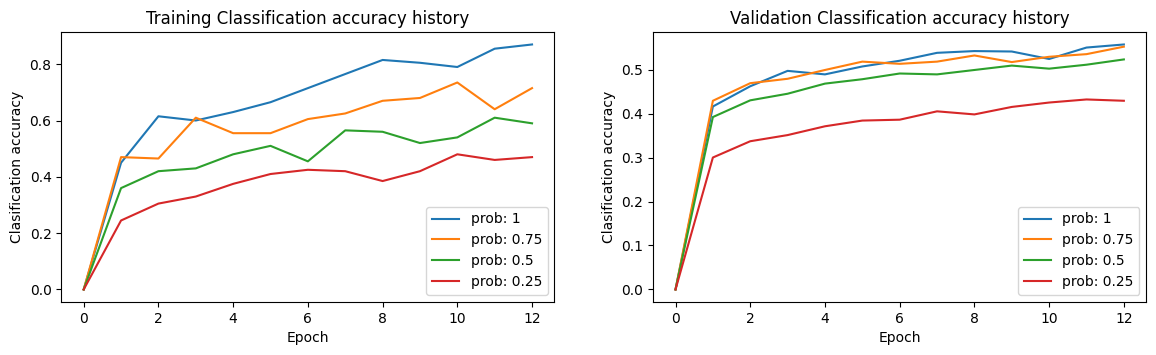

In [40]:
plt.rcParams['figure.figsize'] = [14, 3.5]
plt.subplots_adjust(wspace=0.2)

plt.subplot(121)
for prob in probs:
    plt.plot(history[prob][1], label='prob: '+str(prob))
plt.title('Training Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.legend()

plt.subplot(122)
for prob in probs:
    plt.plot(history[prob][2], label='prob: '+str(prob))
plt.title('Validation Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.legend()
plt.show()

**EXPECTED OUTPUT**:

The images should be similar to:

|train |val |
|------|------|
|![plot1](https://image.ibb.co/jBmQoe/plot1.png) |![plot1](https://image.ibb.co/fiujgz/plot2.png)|


You'll see that using dropout may decrease the training and validation accuracy, since not all neuron used during training

However, using the right dropout, the validation accuracy may not decrease too much

---
### d. Compare Overfitting

The main objective of using Dropout is using it as a Regularizer to prevent Overfitting.

To show that, let's compare the training and validation accuracy over epoch for each Dropout Probability

We know that the greater distance between train and validation accuracy means stronger overfitting

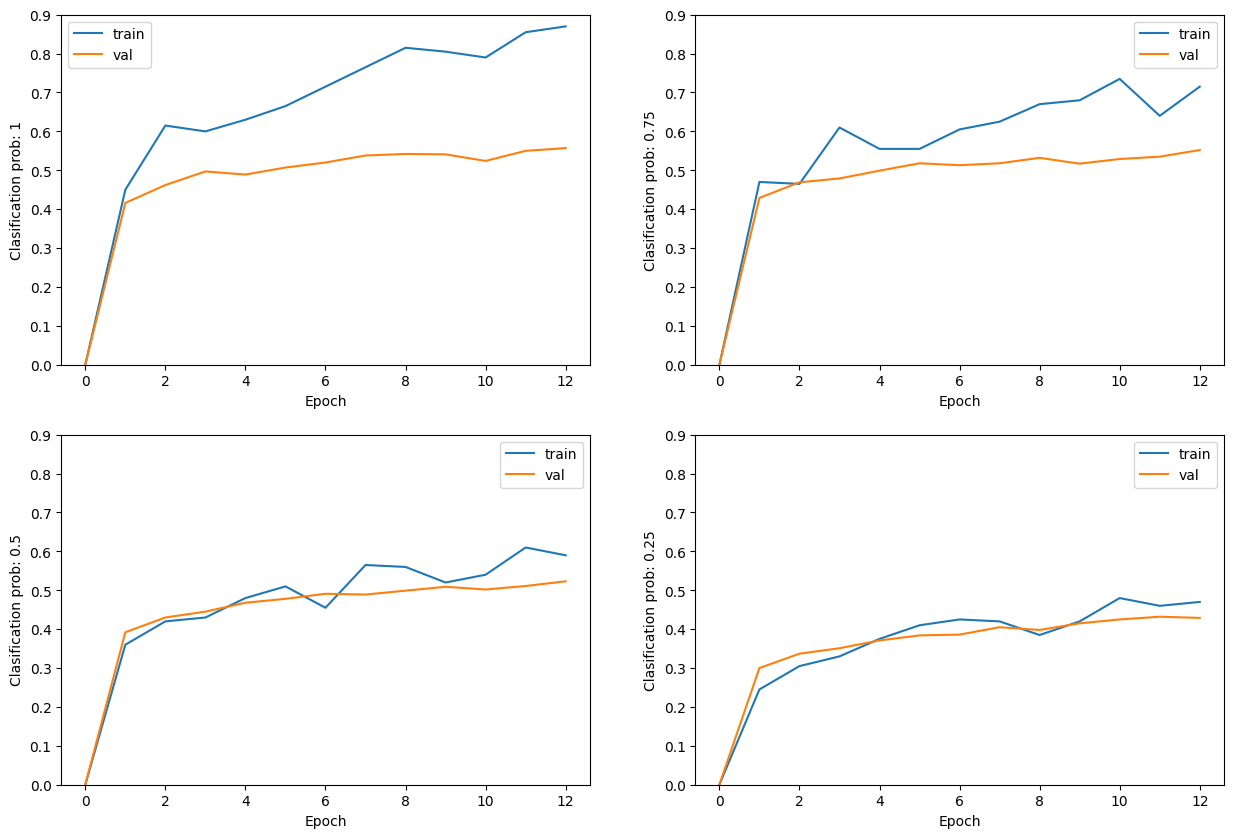

In [41]:
plt.rcParams['figure.figsize'] = [15, 10]
i=0
for prob in probs:
    i+=1
    plt.subplot(2, 2, i)
    plt.plot(history[prob][1], label='train')
    plt.plot(history[prob][2], label='val')
    plt.xlabel('Epoch')
    plt.ylabel('Clasification prob: '+str(prob))
    plt.ylim(0,.9)
    plt.legend()
plt.show()


**EXPECTED OUTPUT**:

* You'll see that using dropout will **prevent overfitting** as the training accuracy and validation accuracy plot difference is as not far as without dropout

* Thus, from this exercise, it can be seen that using dropout with **0.75 probability** is better

<br>



---
---
# [Part 5] Comparing Optimizers

Now let's train another set of 4 Layered Neural Networks to compare the result between models trained with **various optimization schemas**

---
## a. Define Model

For greater effect on the optimizer, we'll use **200 neurons** in each hidden layer

In [42]:
# architecture options:
# input, input_size
# affine, hidden_size
# dropout, dropout_prob

def model_optim():

    architecture =[
        ['input', 32*32*3],
        ['affine', 200],
        ['affine', 200],
        ['affine', 200],
        ['affine', 10]
    ]

    return init_model(architecture)


---
## b. Train Models

Train model for each optimization function using **learning_rate = 1e-4**, then compare the train-val accuracy



<font color='red'>*Note: it took **several minutes** to train it all*

#### <font color='red'>**EXERCISE:** </font>

Use the Training Function and train a **four layer neural network** with **dropout** using **Vanilla SGD**


In [43]:
optims = [sgd, momentum, nag, adagrad, rmsprop, adam]

models_o = {}
history_o = {}

for optim in optims:
    print('-------------------\n')
    print('Try Optimizer =', optim.__name__)

    models_o[optim] = model_optim()

    optim_param = {'lr':1e-4}
    models_o[optim], history_o[optim]= train(models_o[optim],
                                           X_train, y_train,
                                           X_val, y_val,
                                           optim, optim_param,
                                           lr_decay=0.9, reg=0.005,
                                           batch_size=200, epochs=12,
                                           print_every=500)

    y_pred = predict(models_o[optim], X_train)
    accuracy = sklearn.metrics.accuracy_score(y_train, y_pred)
    print('Training Accuracy   = %.1f%%' % (accuracy*100))

    y_pred = predict(models_o[optim], X_val)
    accuracy = sklearn.metrics.accuracy_score(y_val, y_pred)
    print('Validation Accuracy = %.1f%%' % (accuracy*100))
    print()



-------------------

Try Optimizer = sgd
start training
iteration 1 / 2940 	(epoch 1 / 12 ): 	loss = 2.6503007455621517
iteration 501 / 2940 	(epoch 3 / 12 ): 	loss = 2.64582492586309
iteration 1001 / 2940 	(epoch 5 / 12 ): 	loss = 2.639587683501735
iteration 1501 / 2940 	(epoch 7 / 12 ): 	loss = 2.6406592013595636
iteration 2001 / 2940 	(epoch 9 / 12 ): 	loss = 2.625250597902047
iteration 2501 / 2940 	(epoch 11 / 12 ): 	loss = 2.5998224664854304
Training Accuracy   = 19.3%
Validation Accuracy = 19.9%

-------------------

Try Optimizer = momentum
start training
iteration 1 / 2940 	(epoch 1 / 12 ): 	loss = 2.650725192987727
iteration 501 / 2940 	(epoch 3 / 12 ): 	loss = 2.562053671100923
iteration 1001 / 2940 	(epoch 5 / 12 ): 	loss = 2.2457090084243565
iteration 1501 / 2940 	(epoch 7 / 12 ): 	loss = 2.2527225844108822
iteration 2001 / 2940 	(epoch 9 / 12 ): 	loss = 2.0104760534919057
iteration 2501 / 2940 	(epoch 11 / 12 ): 	loss = 1.983241241555285
Training Accuracy   = 41.5%
Validat

**EXPECTED OUTPUT**:
<pre>
loss should starts around 2.6 and ends
  around 2.6 for Vanilla SGD
  around 1.9 for SGD with Momentum
  around 2.0 for Nesterov Update
  around 1.9 for AdaGrad Update
  around 1.1 for RMSProp Update
  around 1.2 for Adam Update

---
## c. Visualize Training
Visualize the train-validation accuracy

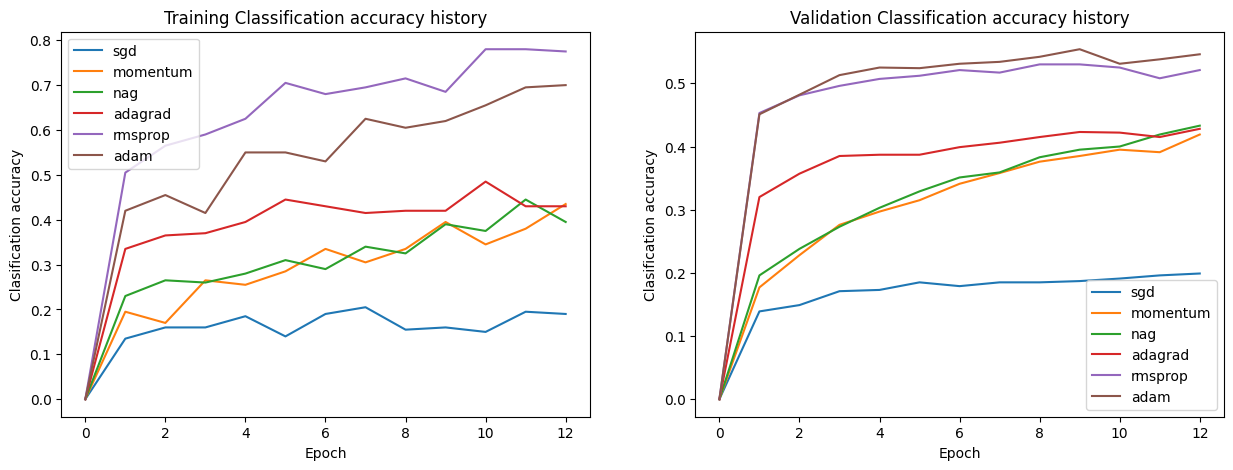

In [44]:
plt.rcParams['figure.figsize'] = [15, 5]
plt.subplots_adjust(wspace=0.2)

plt.subplot(121)
for optim in optims:
    plt.plot(history_o[optim][1], label= optim.__name__)
plt.title('Training Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.legend()

plt.subplot(122)
for optim in optims:
    plt.plot(history_o[optim][2], label= optim.__name__)
plt.title('Validation Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.legend()
plt.show()


**Expected Output**:

The images should be similar to:

|train |val |
|------|------|
|![plot1](https://image.ibb.co/fmAbTe/plot3.png) |![plot1](https://image.ibb.co/kkXZEK/plot4.png)|


Notice the difference in training and validation accuracy using different optimization method:
* You'll see that using **Vanilla SGD** with a really small learning rate, the loss is barely changing

* Using **SGD with Momentum**, **Nesterov Accelerated**, or **AdaGrad** will make the network keep learning (updating its weights) even with small learning rate

* **SGD with Momentum** and **Nesterov Accelerated** even start to picking up its speed to match the **AdaGrad**

* The learning speed is greatly increased when using **RMSProp** and **Adam Update**



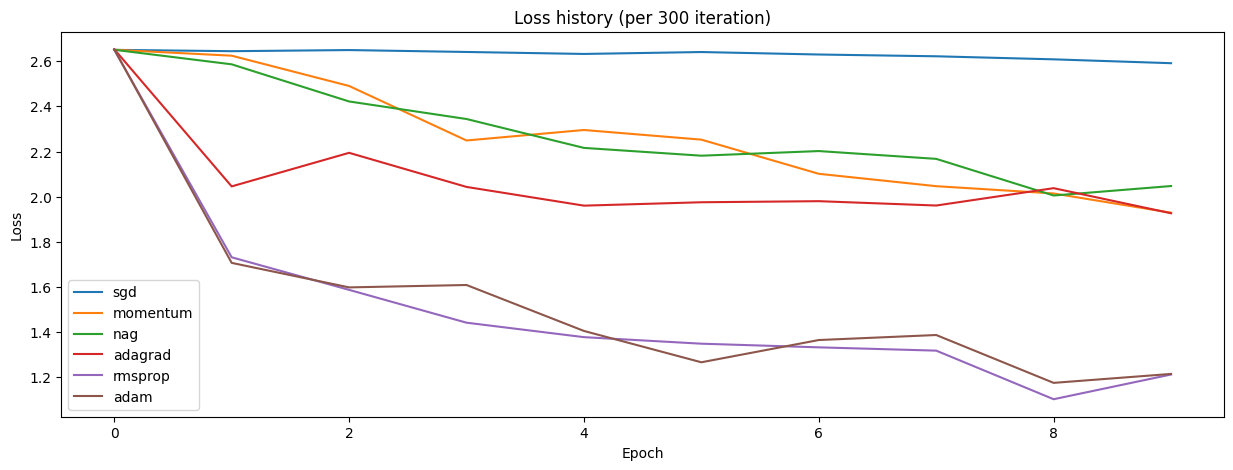

In [45]:
for optim in optims:
    plt.plot(history_o[optim][0][::300], label=optim.__name__)
plt.title('Loss history (per 300 iteration)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Detailed Loss for each Optimization Schemes

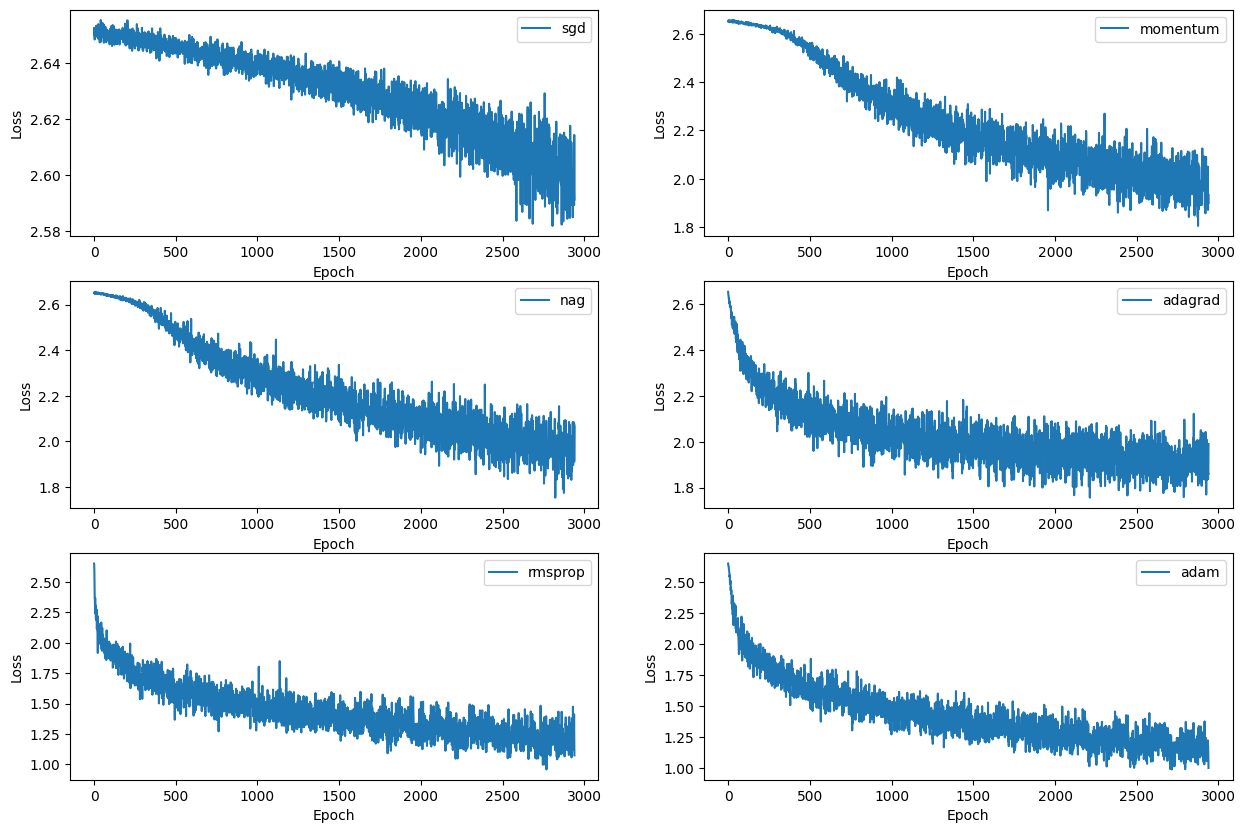

In [46]:
plt.rcParams['figure.figsize'] = [15, 10]
i=0
for optim in optims:
    i+=1
    plt.subplot(3, 2, i)
    plt.plot(history_o[optim][0], label=optim.__name__)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
plt.show()


---
## d. Compare Overfitting

Now Let's compare the overfitting rate

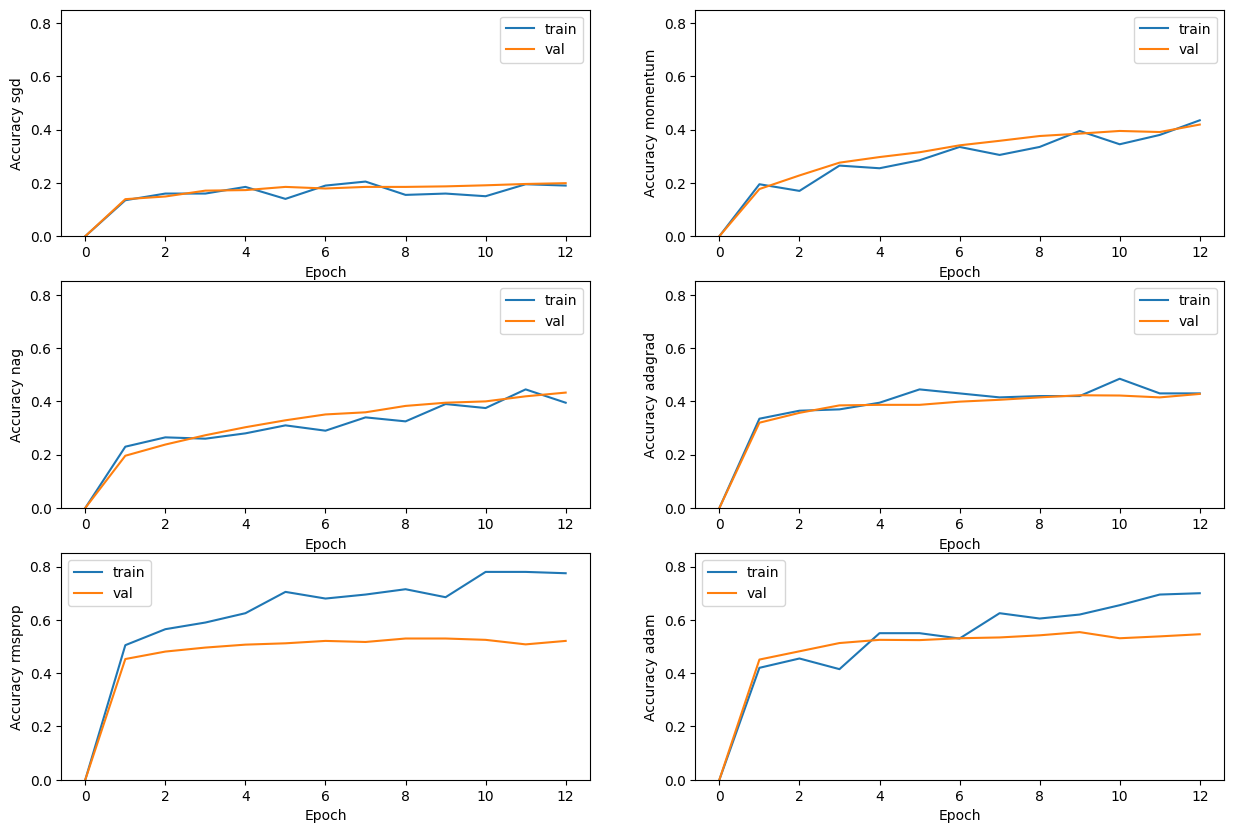

In [47]:
plt.rcParams['figure.figsize'] = [15, 10]
i=0
for optim in optims:
    i+=1
    plt.subplot(3, 2, i)
    plt.plot(history_o[optim][1], label='train')
    plt.plot(history_o[optim][2], label='val')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy '+optim.__name__)
    plt.ylim(0,.85)
    plt.legend()
plt.show()


---
---
# Congratulation, You've Completed Exercise 6
